In [2]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets
from collections import Counter
from model import MarginLoss, make_model
from torch.optim import lr_scheduler
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
import seaborn as sns
import numpy as np
from tqdm import tqdm
import io
from PIL import Image, ImageFilter
import time
import aiohttp

In [3]:
class ApplyMedianFilter(object):
    """
    Applies a Median Filter to the image.

    Args:
    - size (int): The size of the median filter.
    """
    def __init__(self, size: int = 3):
        self.size = size

    def __call__(self, img: Image.Image) -> Image.Image:
        """
        Apply the Median Filter to the given image.

        Args:
        - img (PIL.Image.Image): The input image.

        Returns:
        - PIL.Image.Image: The image after applying the Median Filter.
        """
        return img.filter(ImageFilter.MedianFilter(self.size))

In [4]:
# Define the transfer learning dataset
data_path = 'numbers'

transfer_target_dataset = datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28, 28)),
        ApplyMedianFilter(size=3),
        transforms.ToTensor(),
]))

class_mapping = transfer_target_dataset.class_to_idx
class_mapping

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8}

In [5]:
# Split data to test and train
# Use 80% to train
train_size = int(0.8 * len(transfer_target_dataset))
test_size = len(transfer_target_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(transfer_target_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

print('Train size: ', len(train_dataset))
print('Test size: ', len(test_dataset))

Train size:  12780
Test size:  3195


In [6]:
# Label distribution
train_classes = [label for _, label in transfer_target_dataset]
Counter(train_classes)

Counter({0: 1761,
         1: 1743,
         2: 1801,
         3: 1741,
         4: 1847,
         5: 1781,
         6: 1779,
         7: 1777,
         8: 1745})

In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

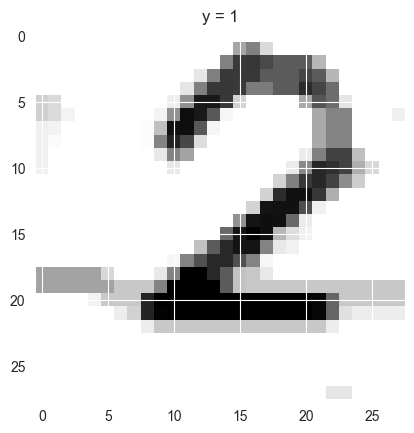

In [8]:
# Check a sample
sample = next(iter(train_loader))

plt.imshow(sample[0][0].reshape(28, 28), cmap='gray')
plt.title('y = {}'.format(sample[1][0]))
plt.show()

In [9]:
model = make_model()
model.load_state_dict(torch.load('checkpoints/019_model_dict_reconstructionTrue.pth')['model_state_dict'])

model.train()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

EfficientCapsNetWithReconstruction(
  (efficient_capsnet): EfficientCapsNet(
    (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
    (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=valid)
    (batch_norm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (primary_caps): PrimaryCapsLayer(
      (depthwise_conv): Conv2d(128, 128, kernel_size=(9, 9), stride=(1, 1), padding=valid, groups=128)
    )
    (digit_caps): RoutingLayer()
  )
  (reconstruction_net): Recons

In [10]:
args = {
    "batch_size": 64,
    "test_batch_size": 64,
    "epochs": 30,
    "lr": 3e-4,
    "reconstruction_alpha": 0.0005,
}

optimizer = optim.Adam(model.parameters(), lr=args["lr"])

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, verbose=True, factor=0.9, patience=4, min_lr=1e-5, mode="max"
)

loss_fn = MarginLoss(0.9, 0.1, 0.5)

In [11]:
confusion_mat = np.zeros((9, 9), dtype=int)
max_test_accuracy = 0

def train(current_epoch):
    model.train()
    # 將train_loader包裝在tqdm進度條中
    train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Train Epoch: {current_epoch}')
    for batch_idx, (data, target) in train_loader_tqdm:
        data, target = data.to(device), target.to(device)
        
        data, target = Variable(data), Variable(target, requires_grad=False)
        optimizer.zero_grad()
        
        output, probs = model(data)
        reconstruction_loss = F.mse_loss(output, data.view(-1, 784))
        margin_loss = loss_fn(probs, target)
        loss = args["reconstruction_alpha"] * reconstruction_loss + margin_loss
            
        loss.backward()
        optimizer.step()
        
        # 更新tqdm進度條的描述信息
        train_loader_tqdm.set_description(
            "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                current_epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100.0 * batch_idx / len(train_loader),
                loss.item(),
            )
        )
            
def test(final=False):
    global confusion_mat, max_test_accuracy
    model.eval()
    test_loss = 0
    correct = 0
    if final:
        confusion_mat = np.zeros((9, 9), dtype=int)
    with tqdm(test_loader, unit="batch", desc="Test Set") as test_loader_tqdm:
        for data, target in test_loader_tqdm:
            data, target = data.to(device), target.to(device)
            data, target = Variable(data), Variable(target)

            output, probs = model(data)
            reconstruction_loss = F.mse_loss(
                output, data.view(-1, 784), reduction='sum'
            ).item()
            test_loss += loss_fn(probs, target, size_average=False).item()
            test_loss += args["reconstruction_alpha"] * reconstruction_loss

            pred = probs.data.max(1, keepdim=True)[1]  # get the index of the max probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            if final:
                for i in range(len(pred)):
                    true_label = target.data[i]
                    pred_label = pred.data[i]
                    confusion_mat[true_label][pred_label] += 1
            test_loader_tqdm.set_postfix(Loss=test_loss / len(test_loader.dataset), Accuracy=100.0 * correct / len(test_loader.dataset))
            
        if 100.0 * correct / len(test_loader.dataset) > max_test_accuracy:
            max_test_accuracy = 100.0 * correct / len(test_loader.dataset)
            torch.save(
                model.state_dict(),
                f"checkpoints/{max_test_accuracy:0.2f}_reconstruction_transfer.pth",
            )

    if final:
        sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d")
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title("Efficient CapsNet - MNIST Confusion Matrix")
        plt.savefig("confusion_mat-reconstruction.png")
    return test_loss

Train Epoch: 1 [8756/12780 (100%)]	Loss: 0.004311: 100%|██████████| 200/200 [00:34<00:00,  5.87it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 26.85batch/s, Accuracy=tensor(95.8998), Loss=0.0606]
Train Epoch: 2 [8756/12780 (100%)]	Loss: 0.000976: 100%|██████████| 200/200 [00:07<00:00, 26.08it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 34.80batch/s, Accuracy=tensor(98.5290), Loss=0.0309] 
Train Epoch: 3 [8756/12780 (100%)]	Loss: 0.001524: 100%|██████████| 200/200 [00:07<00:00, 25.92it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 38.99batch/s, Accuracy=tensor(98.9045), Loss=0.0256] 
Train Epoch: 4 [8756/12780 (100%)]	Loss: 0.001373: 100%|██████████| 200/200 [00:07<00:00, 27.14it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.23batch/s, Accuracy=tensor(99.4053), Loss=0.0207] 
Train Epoch: 5 [8756/12780 (100%)]	Loss: 0.001006: 100%|██████████| 200/200 [00:07<00:00, 27.26it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 39.63batch/s, Accuracy=tensor(99.4679), Loss=

Epoch 00006: reducing learning rate of group 0 to 2.7000e-04.


Train Epoch: 7 [8756/12780 (100%)]	Loss: 0.000240: 100%|██████████| 200/200 [00:07<00:00, 26.25it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 39.22batch/s, Accuracy=tensor(99.7496), Loss=0.0147] 
Train Epoch: 8 [8756/12780 (100%)]	Loss: 0.000645: 100%|██████████| 200/200 [00:07<00:00, 27.00it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 39.49batch/s, Accuracy=tensor(99.9061), Loss=0.0141] 
Train Epoch: 9 [8756/12780 (100%)]	Loss: 0.000131: 100%|██████████| 200/200 [00:07<00:00, 26.86it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.32batch/s, Accuracy=tensor(99.7496), Loss=0.0137] 
Train Epoch: 10 [8756/12780 (100%)]	Loss: 0.000122: 100%|██████████| 200/200 [00:07<00:00, 27.13it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.20batch/s, Accuracy=tensor(99.7496), Loss=0.0134] 
Train Epoch: 11 [8756/12780 (100%)]	Loss: 0.000224: 100%|██████████| 200/200 [00:07<00:00, 27.19it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 39.42batch/s, Accuracy=tensor(99.7496), Lo

Epoch 00011: reducing learning rate of group 0 to 2.4300e-04.


Train Epoch: 12 [8756/12780 (100%)]	Loss: 0.000064: 100%|██████████| 200/200 [00:07<00:00, 27.14it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 39.78batch/s, Accuracy=tensor(99.8748), Loss=0.0124] 
Train Epoch: 13 [8756/12780 (100%)]	Loss: 0.000114: 100%|██████████| 200/200 [00:07<00:00, 27.04it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.48batch/s, Accuracy=tensor(99.7183), Loss=0.0129] 
Train Epoch: 14 [8756/12780 (100%)]	Loss: 0.000051: 100%|██████████| 200/200 [00:07<00:00, 27.20it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 38.92batch/s, Accuracy=tensor(99.8122), Loss=0.0124] 
Train Epoch: 15 [8756/12780 (100%)]	Loss: 0.000137: 100%|██████████| 200/200 [00:07<00:00, 27.35it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 39.59batch/s, Accuracy=tensor(99.7809), Loss=0.0122] 
Train Epoch: 16 [8756/12780 (100%)]	Loss: 0.000027: 100%|██████████| 200/200 [00:07<00:00, 27.06it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 39.68batch/s, Accuracy=tensor(99.8122),

Epoch 00016: reducing learning rate of group 0 to 2.1870e-04.


Train Epoch: 17 [8756/12780 (100%)]	Loss: 0.000041: 100%|██████████| 200/200 [00:07<00:00, 27.13it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 39.71batch/s, Accuracy=tensor(99.8122), Loss=0.0117] 
Train Epoch: 18 [8756/12780 (100%)]	Loss: 0.000069: 100%|██████████| 200/200 [00:07<00:00, 26.79it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.06batch/s, Accuracy=tensor(99.8435), Loss=0.0129] 
Train Epoch: 19 [8756/12780 (100%)]	Loss: 0.000050: 100%|██████████| 200/200 [00:07<00:00, 27.37it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 38.08batch/s, Accuracy=tensor(99.9061), Loss=0.0112] 
Train Epoch: 20 [8756/12780 (100%)]	Loss: 0.000034: 100%|██████████| 200/200 [00:07<00:00, 27.14it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 39.45batch/s, Accuracy=tensor(99.9061), Loss=0.0123] 
Train Epoch: 21 [8756/12780 (100%)]	Loss: 0.000046: 100%|██████████| 200/200 [00:07<00:00, 27.04it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.29batch/s, Accuracy=tensor(99.6870),

Epoch 00021: reducing learning rate of group 0 to 1.9683e-04.


Train Epoch: 22 [8756/12780 (100%)]	Loss: 0.000016: 100%|██████████| 200/200 [00:07<00:00, 27.28it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 39.55batch/s, Accuracy=tensor(99.8122), Loss=0.0114] 
Train Epoch: 23 [8756/12780 (100%)]	Loss: 0.000012: 100%|██████████| 200/200 [00:07<00:00, 26.71it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 38.48batch/s, Accuracy=tensor(99.9374), Loss=0.0111] 
Train Epoch: 24 [8756/12780 (100%)]	Loss: 0.000126: 100%|██████████| 200/200 [00:07<00:00, 26.96it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 39.46batch/s, Accuracy=tensor(99.8435), Loss=0.011]  
Train Epoch: 25 [8756/12780 (100%)]	Loss: 0.000023: 100%|██████████| 200/200 [00:07<00:00, 26.91it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 39.33batch/s, Accuracy=tensor(99.8748), Loss=0.0107] 
Train Epoch: 26 [8756/12780 (100%)]	Loss: 0.000119: 100%|██████████| 200/200 [00:07<00:00, 27.07it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.31batch/s, Accuracy=tensor(99.8435),

Epoch 00026: reducing learning rate of group 0 to 1.7715e-04.


Train Epoch: 27 [8756/12780 (100%)]	Loss: 0.000072: 100%|██████████| 200/200 [00:07<00:00, 27.13it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.51batch/s, Accuracy=tensor(99.9061), Loss=0.0106] 
Train Epoch: 28 [8756/12780 (100%)]	Loss: 0.000027: 100%|██████████| 200/200 [00:07<00:00, 27.31it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.11batch/s, Accuracy=tensor(99.7809), Loss=0.0105] 
Train Epoch: 29 [8756/12780 (100%)]	Loss: 0.001218: 100%|██████████| 200/200 [00:07<00:00, 27.48it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.47batch/s, Accuracy=tensor(99.9061), Loss=0.0103] 
Train Epoch: 30 [8756/12780 (100%)]	Loss: 0.000012: 100%|██████████| 200/200 [00:07<00:00, 27.43it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 35.26batch/s, Accuracy=tensor(99.8435), Loss=0.0105] 



 ---------------------------- Finished Training ---------------------------- 


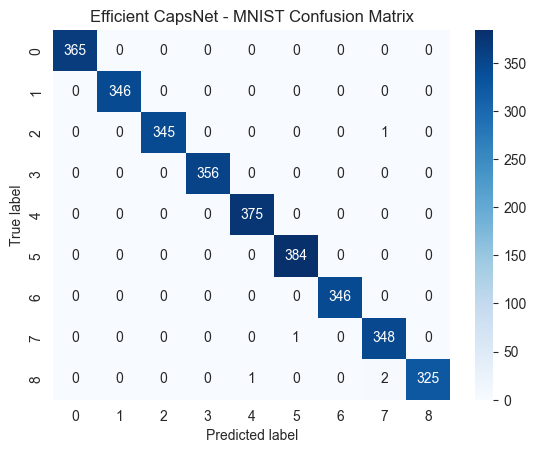

In [12]:
for epoch in range(1, args["epochs"] + 1):
    final = True if epoch == args["epochs"] else False
    train(epoch)
    test_loss = test(final)
    scheduler.step(test_loss)
    if epoch % 10 == 0 or epoch == args["epochs"]:
        # Save the model dict
        torch.save(
            model.state_dict(),
            f"checkpoints/{epoch:03d}_model_dict_reconstruction_transfer.pth",
        )

print("\n", "-" * 28, "Finished Training", "-" * 28, "\n")

In [27]:
# Load the best model
model.load_state_dict(torch.load('checkpoints/99.94_reconstruction_transfer.pth'))

<All keys matched successfully>

In [28]:
# For deployment, we only need the convolutional layers, no need for the decoder
deploy_model = model.efficient_capsnet
deploy_model

EfficientCapsNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  (batch_norm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (primary_caps): PrimaryCapsLayer(
    (depthwise_conv): Conv2d(128, 128, kernel_size=(9, 9), stride=(1, 1), padding=valid, groups=128)
  )
  (digit_caps): RoutingLayer()
)

In [44]:
# Save the model
torch.save(deploy_model.state_dict(), 'checkpoints/EfficientCapsNetDeploy.pth')

In [30]:
# Check the model output shape
deploy_model.eval()
sample = next(iter(train_loader))
output, prob = deploy_model(sample[0].to(device))
output.shape

torch.Size([64, 10, 16])

In [31]:
prob.shape

torch.Size([64, 10])

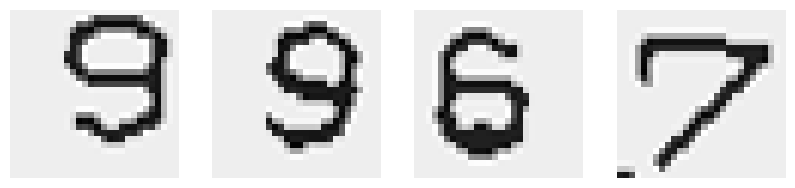

9967


In [42]:
import asyncio

BASEURL = "https://selcrs.nsysu.edu.tw/menu1"
MODULE_PATH = "checkpoints/efficient_capsnet_deploy.pth"

def parse_valid_code(img: bytes):
    # Load the image
    image = Image.open(io.BytesIO(img))

    # Convert the image to grayscale
    image = image.convert("L")

    # Apply Median Filter to reduce noise
    image = image.filter(ImageFilter.MedianFilter(size=3))

    # Get the width of the image
    width = image.size[0]

    # Determine the size of each slice
    slice_width = width // 4

    # Create a list to hold the image slices
    slices = []

    # Slice the image and resize each slice
    for i in range(4):
        slice_img = image.crop(
            (i * slice_width, 0, (i + 1) * slice_width, image.size[1])
        )
        # Resize and apply Median Filter again to ensure consistency after cropping
        slice_img = slice_img.resize((28, 28))
        slices.append(slice_img)

    # Determine the device to use
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert the slices to a NumPy array and normalize the pixel values
    slices = np.array([np.array(slice_img) / 255.0 for slice_img in slices])

    # Load the model weights
    deploy_model.load_state_dict(torch.load(MODULE_PATH, map_location=device))
    deploy_model.to(device)
    deploy_model.eval()

    # Convert slices to a tensor, normalize and add a batch dimension
    slices_tensor = torch.tensor(slices, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    slices_tensor = slices_tensor.to(device)  # Move the slices tensor to the correct device
    
    # Plot the slices
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
    for i, ax in enumerate(axes):
        ax.imshow(slices[i], cmap="gray")
        ax.axis("off")
    
    plt.show()
    
    with torch.no_grad():
        _, predictions = deploy_model(slices_tensor)

    # Get the predicted classes
    predicted_classes = torch.argmax(predictions, dim=1).cpu().numpy() + 1

    return "".join(map(str, predicted_classes))

async with aiohttp.ClientSession() as s:
    async with s.get(f"{BASEURL}/validcode.asp?epoch={time.time()}") as out:
        img = await out.read()
        code = parse_valid_code(img)
        print(code)